In [9]:
# 1. Load Libraries
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, janitor, naniar, visdat, here)

# 2. Load Data from disk (Links to Notebook 01)
wb_data <- read_csv("../data/world_bank_raw.csv", show_col_types = FALSE)

# Load the original HDI data
hdi_raw <- read_csv("../data/HDI_data.csv", show_col_types = FALSE)

print("Data Loaded Successfully!")
print(paste("World Bank Rows:", nrow(wb_data)))
print(paste("HDI Rows:", nrow(hdi_raw)))

[1] "Data Loaded Successfully!"
[1] "World Bank Rows: 6118"
[1] "HDI Rows: 206"


In [10]:
wb_clean <- wb_data %>%
  # Filter out aggregates (region is usually NA or "Aggregates" for non-countries)
  filter(!is.na(region), region != "Aggregates") %>%
  # Select only the columns we need
  select(
    iso3c, 
    country_wb = country, # Rename to avoid confusion with HDI country name
    year, 
    gdp_per_capita, 
    life_expectancy_wb = life_expectancy, 
    unemployment_rate, 
    education_expenditure, 
    health_expenditure
    # Note: co2_emissions is removed because it failed to download
  ) %>%
  mutate(year = as.integer(year))

print(paste("World Bank Cleaned Rows:", nrow(wb_clean)))
head(wb_clean)

[1] "World Bank Cleaned Rows: 4945"


iso3c,country_wb,year,gdp_per_capita,life_expectancy_wb,unemployment_rate,education_expenditure,health_expenditure
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Afghanistan,2012,568.9290,61.735,7.856,2.60420,7.897169
AFG,Afghanistan,2016,563.8723,62.646,10.133,4.54397,11.818590
AFG,Afghanistan,2017,562.7696,62.406,11.184,4.34319,12.620817
AFG,Afghanistan,2011,525.4270,61.250,7.784,3.46201,8.561908
AFG,Afghanistan,2000,308.3183,55.005,7.935,NA,NA
AFG,Afghanistan,2013,580.6038,62.188,7.930,3.45446,8.805964


In [11]:
# Define the specific indicators we want to keep to avoid "hdi_f" (female) or ranks
target_indicators <- c("hdi", "gnipc", "le", "eys", "mys")

hdi_clean <- hdi_raw %>%
  # 1. Select ID columns and columns ending in a 4-digit year
  select(iso3, country, region, matches("_[0-9]{4}$")) %>%
  
  # 2. Pivot using Regex to strictly separate "Indicator_Name" from "Year"
  pivot_longer(
    cols = -c(iso3, country, region),
    names_to = c("indicator", "year"),
    names_pattern = "^(.*)_([0-9]{4})$" # Captures "name" before the last underscore, "year" after
  ) %>%
  
  # 3. Fix year and filter for only the indicators we care about
  mutate(year = as.integer(year)) %>%
  filter(indicator %in% target_indicators) %>%
  
  # 4. Pivot Wider: Now safe because duplicates are removed
  pivot_wider(
    names_from = indicator,
    values_from = value
  ) %>%
  
  # 5. Filter timeline and rename ISO code
  filter(year >= 2000, year <= 2022) %>%
  rename(iso3c = iso3)

print(paste("HDI Cleaned Rows:", nrow(hdi_clean)))
head(hdi_clean)

[1] "HDI Cleaned Rows: 4738"


iso3c,country,region,year,hdi,le,eys,mys,gnipc
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Afghanistan,SA,2000,0.351,55.005,5.856422,1.264052,1331.140
AFG,Afghanistan,SA,2001,0.355,55.511,6.148418,1.315551,1246.158
AFG,Afghanistan,SA,2002,0.383,56.225,6.440414,1.367049,1946.696
AFG,Afghanistan,SA,2003,0.392,57.171,6.732410,1.418548,1982.540
AFG,Afghanistan,SA,2004,0.408,57.810,7.600430,1.470046,1963.735
AFG,Afghanistan,SA,2005,0.417,58.247,7.858030,1.521544,2084.058


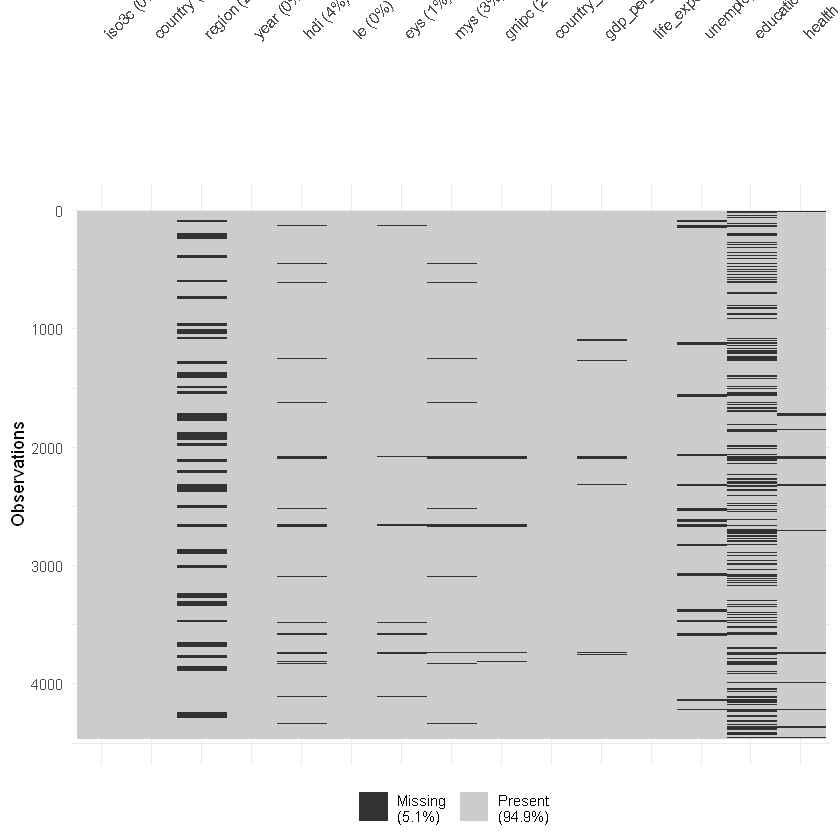

In [12]:
master_data <- inner_join(hdi_clean, wb_clean, by = c("iso3c", "year")) %>%
  clean_names() # Ensures all column names are lowercase/snake_case

# Calculate a "Missingness Score" per country to see data quality
# This is great for the report
vis_miss(master_data, warn_large_data = FALSE)

In [13]:
master_data_imputed <- master_data %>%
  group_by(country) %>%
  fill(
    gdp_per_capita, unemployment_rate, education_expenditure, health_expenditure,
    .direction = "downup" # Fill missing values down, then up
  ) %>%
  ungroup() %>%
  # Drop rows that are STILL missing the Target Variable (HDI)
  drop_na(hdi)

print("Final Master Data Summary:")
glimpse(master_data_imputed)

# Save the master file
write_csv(master_data_imputed, "../data/master_data_final.csv")
print("Data cleaning complete. File saved to data/master_data_final.csv")

[1] "Final Master Data Summary:"
Rows: 4,290
Columns: 15
$ iso3c                 <chr> "AFG", "AFG", "AFG", "AFG", "AFG", "AFG", "AFG",…
$ country               <chr> "Afghanistan", "Afghanistan", "Afghanistan", "Af…
$ region                <chr> "SA", "SA", "SA", "SA", "SA", "SA", "SA", "SA", …
$ year                  <int> 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, …
$ hdi                   <dbl> 0.351, 0.355, 0.383, 0.392, 0.408, 0.417, 0.426,…
$ le                    <dbl> 55.005, 55.511, 56.225, 57.171, 57.810, 58.247, …
$ eys                   <dbl> 5.856422, 6.148418, 6.440414, 6.732410, 7.600430…
$ mys                   <dbl> 1.264052, 1.315551, 1.367049, 1.418548, 1.470046…
$ gnipc                 <dbl> 1331.140, 1246.158, 1946.696, 1982.540, 1963.735…
$ country_wb            <chr> "Afghanistan", "Afghanistan", "Afghanistan", "Af…
$ gdp_per_capita        <dbl> 308.3183, 277.1181, 338.1400, 346.0716, 338.6373…
$ life_expectancy_wb    <dbl> 55.005, 55.511, 56.225, 57.171, 5